<a href="https://colab.research.google.com/github/felipemoran/rob313_tp3/blob/master/CTP_3_Felipe_MORAN_Model_A_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 - ROB313
### Felipe MORAN 

This is a simplified version of the original notebook cointaining only the code needed to test different CNN structures and parameters.

## Setup

### Plotting functions and useful **imports**

In [0]:
%matplotlib inline

# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Install PyTorch and Torchvision



In [0]:
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

### Imports

In [0]:
import numpy as np
import torch as th
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import files
import datetime 
import copy


### Seed the random generator to have reproducible results:

In [0]:
# seed = 42
# np.random.seed(seed)
# torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
#   th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")


### Define subset of the dataset

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 40000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

### Apply transformations do dataset

In [0]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(size=32,padding=4),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

### Separate dataset in train/test set

In [0]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Extra

In [0]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

### Show sample images



      deer       bird      horse      horse


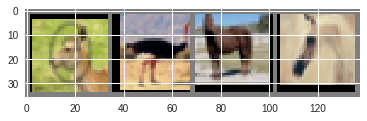

In [0]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [0]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

### Define a loss function and optimizer

In [0]:
def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

### Data loader

In [0]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

### Training loop

In [0]:
def train(net, batch_size, n_epochs, learning_rate, start_epoch=1):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      start_epoch + epoch, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

### Performance calculation functions

In [0]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    print("Computing accuracy...")
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f} ({:^6}/{:^6})'.format(classes[i], percentage_correct, class_correct, class_total))
    return confusion_matrix


## CNN Architecture

In [0]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv11 = nn.Conv2d(3,     64,   kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64,    128,   kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm1 = nn.BatchNorm2d(128)
        
        self.conv21 = nn.Conv2d(128,  128,   kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(128,  256,   kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm2 = nn.BatchNorm2d(256)
        
        self.conv31 = nn.Conv2d(256,  256,   kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(256,  512,   kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm3 = nn.BatchNorm2d(512)
        
        self.conv41 = nn.Conv2d(512,  512,   kernel_size=3, stride=1, padding=1)
        self.conv42 = nn.Conv2d(512,  1024,   kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm4 = nn.BatchNorm2d(1024)
        
        self.conv51 = nn.Conv2d(1024, 1024,  kernel_size=3, stride=1, padding=1)
        self.conv52 = nn.Conv2d(1024, 2048,  kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm5 = nn.BatchNorm2d(2048)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
#         self.drop1 = nn.Dropout(p=0.1)
#         self.drop2 = nn.Dropout(p=0.2)
#         self.drop3 = nn.Dropout(p=0.3)
#         self.drop4 = nn.Dropout(p=0.4)
#         self.drop5 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool1(x)
        x = self.bnorm1(x)
#         x = self.drop1(x)
        
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.pool2(x)
        x = self.bnorm2(x)
#         x = self.drop2(x)
        
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = self.pool3(x)
        x = self.bnorm3(x)
#         x = self.drop3(x)
        
        x = F.relu(self.conv41(x))
        x = F.relu(self.conv42(x))
        x = self.pool4(x)
        x = self.bnorm4(x)
#         x = self.drop4(x)
        
        x = F.relu(self.conv51(x))
        x = F.relu(self.conv52(x))
        x = self.pool5(x)
        x = self.bnorm5(x)
#         x = self.drop5(x)
        
        x = x.view(-1, 2048)
        x = F.relu(self.fc1(x))
#         x = self.drop5(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
      
        return x

## Performance evaluation

### Instantiate network

In [0]:
train_history = []
val_history = []
cnn_copies = [MyConvolutionalNetwork()]
last_epoch = 0

### Train network

In [0]:
epochs_to_train = 20
save_intervals = 3

for i in range(epochs_to_train):
    last_epoch += 1
    print("------------- Epoch: {}".format(last_epoch))
    train_history_partial, val_history_partial = train(cnn_copies[-1], batch_size=32, n_epochs=1, learning_rate=0.001, start_epoch=last_epoch)

    train_history += train_history_partial
    val_history += val_history_partial
    
    if (i+1)%save_intervals == 0:
        cnn_copies.append(copy.deepcopy(cnn_copies[-1]))
        

------------- Epoch: 21
===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 1
learning_rate= 0.001
Epoch 21, 10% 	 train_loss: 0.43 took: 15.08s
Epoch 21, 20% 	 train_loss: 0.46 took: 14.82s
Epoch 21, 30% 	 train_loss: 0.42 took: 14.74s
Epoch 21, 40% 	 train_loss: 0.41 took: 14.71s
Epoch 21, 50% 	 train_loss: 0.45 took: 14.72s
Epoch 21, 60% 	 train_loss: 0.41 took: 14.66s
Epoch 21, 70% 	 train_loss: 0.43 took: 14.64s
Epoch 21, 80% 	 train_loss: 0.39 took: 14.71s
Epoch 21, 90% 	 train_loss: 0.39 took: 14.67s
Validation loss = 0.57
Training Finished, took 151.00s
------------- Epoch: 22
===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 1
learning_rate= 0.001
Epoch 22, 10% 	 train_loss: 0.45 took: 14.75s
Epoch 22, 20% 	 train_loss: 0.45 took: 14.65s
Epoch 22, 30% 	 train_loss: 0.47 took: 14.62s
Epoch 22, 40% 	 train_loss: 0.42 took: 14.66s
Epoch 22, 50% 	 train_loss: 0.43 took: 14.65s
Epoch 22, 60% 	 train_loss: 0.41 took: 14.65s
Epoch 22, 70% 	 train_loss: 0.42 took: 14.63s
Epoch 22,

In [0]:
timestamp = str(datetime.datetime.now())
torch.save(cnn_copies[-1].state_dict(), "model_A_" + str(last_epoch) + "_" + timestamp + ".pwf") 
files.download("model_A_" + str(last_epoch) + "_" + timestamp + ".pwf")

### Losses plot

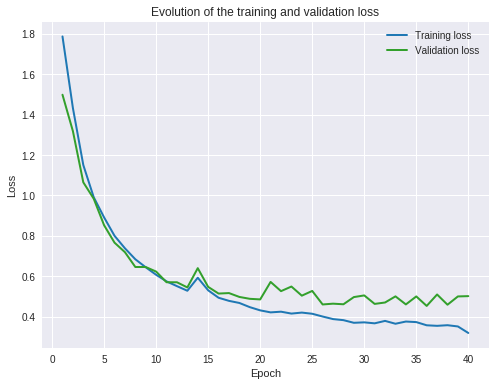

In [0]:
  plot_losses(train_history, val_history)

### Performance indicators


In [0]:
compute_accuracy(cnn_copies[-1])

Computing accuracy...
Accuracy of the network on the 40000 train images: 83.35 %
Accuracy of the network on the 5000 validation images: 87.64 %
Accuracy of the network on the 5000 test images: 79.20 %


In [0]:
confusion_matrix = accuracy_per_class(cnn_copies[-1])

Class      Accuracy (%)
plane        69.88    ( 341  / 488  )
car          88.71    ( 448  / 505  )
bird         64.26    ( 329  / 512  )
cat          63.58    ( 316  / 497  )
deer         73.57    ( 373  / 507  )
dog          68.65    ( 335  / 488  )
frog         75.56    ( 371  / 491  )
horse        73.33    ( 363  / 495  )
ship         86.11    ( 434  / 504  )
truck        82.46    ( 423  / 513  )


### Confusion Matrix

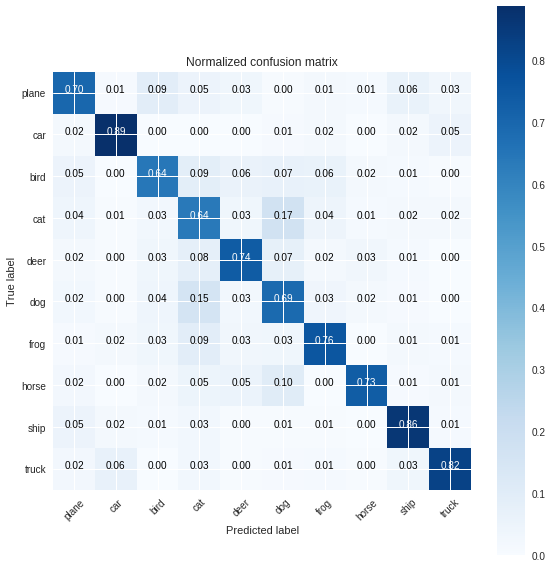

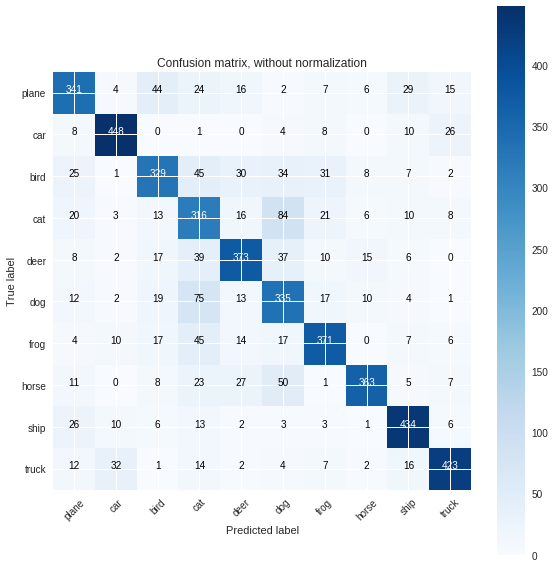

In [0]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')